In [1]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt
import pysemp.pysemp as SEMP
import pyswarms
#import radiospectra
#from radiospectra.spectrogram2 import sources
%load_ext autoreload
%autoreload 2

In [3]:
[r_STA,r_WI,r_PSP] = [0.9669,1.0015*0.99,0.2266]
[alpha_STA,alpha_WI,alpha_PSP] = np.array([-97.1256,0,-342.8451]) *np.pi/180

In [4]:
PSPdataset = np.load('../../SEMPdemo/20200721/npz/psp_LE.npz',allow_pickle=True)
WISTAdataset = np.load('../../SEMPdemo/20200721/npz/WI_STA_LE.npz')
STAdataset = np.load('../../SEMPdemo/20200721/npz/STA_data.npz')
WIdataset = np.load('../../SEMPdemo/20200721/npz/WI_data.npz')

In [5]:
freq_PSP = PSPdataset['freq_PSP']
t_PSP = PSPdataset['t_PSP']
freq_WI  = WISTAdataset['freq_WI']*1e3
freq_STA = WISTAdataset['freq_STA']*1e3
t_WI  = WISTAdataset['t_WI']
t_STA = WISTAdataset['t_STA']

data_WI = WIdataset['data_WI']
data_STA = STAdataset['data_STA']
ds_t_WI = WIdataset['ds_t_WI']
ds_f_WI = WIdataset['ds_f_WI']*1e3
ds_t_STA = STAdataset['ds_t_STA']
ds_f_STA = STAdataset['ds_f_STA']*1e3

anchor_dt = PSPdataset['anchor_dt']
data_PSP = PSPdataset['data_PSP']
ds_t_PSP = PSPdataset['ds_t_PSP']
ds_f_PSP = PSPdataset['ds_f_PSP']

In [6]:
# x: [t0,theta0,vs]
v_sw = 400
Min_Func = lambda x:( SEMP.Dt_STA_WI_PSP(freq_STA,freq_WI,freq_PSP,
        t_STA,t_WI,t_PSP, x[:,0],x[:,1],x[:,2],v_sw,alpha_STA,alpha_WI,
        alpha_PSP,r_STA,r_WI,r_PSP,Ne_par=2.0) )


In [7]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of GlobalBestPSO
optimizer = pyswarms.single.GlobalBestPSO(n_particles=50, dimensions=3,
                                    options=options,bounds=([0,-0*np.pi,0],[5000,2*np.pi,3e5]))

In [8]:

stats = optimizer.optimize(Min_Func, iters=100)

2023-05-02 22:36:17,268 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=18.5
2023-05-02 22:36:18,944 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.473560148529167, best pos: [2.13666271e+03 4.65665676e+00 3.46842013e+04]


In [9]:
f_model = np.logspace(4.5,7,30)
t_model_STA = np.zeros(f_model.shape)
t_model_WI = np.zeros(f_model.shape)
t_model_PSP = np.zeros(f_model.shape)

for idx,freq in enumerate(f_model):
    t_model_PSP[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_PSP,r_satellite_AU=r_PSP,Ne_par=2.0)
    t_model_STA[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_STA,r_satellite_AU=r_STA,Ne_par=2.0)
    t_model_WI[idx]  =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_WI,r_satellite_AU=r_WI,Ne_par=2.0)

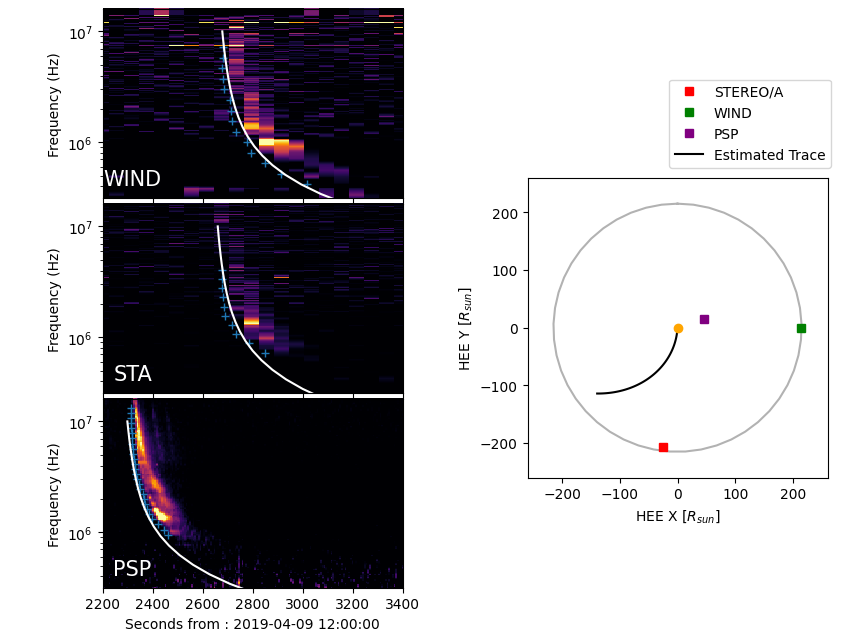

In [29]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(5,6.5)) 
ax = fig.add_axes([0.15,0.2,0.6,0.29])
ax1 = fig.add_axes([0.15,0.5,0.6,0.29])
ax2 = fig.add_axes([0.15,0.8,0.6,0.29])

ax.set_xlabel('Seconds from : '+str(anchor_dt))

# plot three dynamic spectra
im_list = []
for namethis,ax_this,ds_t_this,ds_f_this,data_this in zip(['PSP','STA','WIND'],[ax,ax1,ax2],
          [ds_t_PSP,ds_t_STA,ds_t_WI],[ds_f_PSP,ds_f_STA,ds_f_WI],[data_PSP,data_STA,data_WI]):
     im_this=NonUniformImage(ax_this, interpolation='nearest',
                             extent=[ds_t_this[0],ds_t_this[-1],ds_f_this[0],ds_f_this[-1]],cmap='inferno')
     lin_freq = np.linspace(ds_f_this[0],ds_f_this[-1],ds_f_this.shape[0])
     im_this.set_data(ds_t_this,lin_freq,(data_this.T))
     ax_this.add_image(im_this)
     ax_this.set_aspect('auto', 'datalim')
     ax_this.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
     ax_this.text(0.1, 0.1,namethis,
          color='w',ha='center',va='center',transform = ax_this.transAxes,fontsize=15)
     im_list.append(im_this)
     plt.setp(ax_this,yscale='log',ylabel='Frequency (Hz)',xlim=[2200,3400], ylim=[ds_f_this[0],ds_f_this[-1]])

im_list[0].set_clim([0,3e-16])
im_list[1].set_clim([0,2])
im_list[2].set_clim([0,0.1])

# leading edge points
ax.plot(t_PSP,freq_PSP,'C0+')
ax1.plot(t_STA,freq_STA,'C0+')
ax2.plot(t_WI,freq_WI,'C0+')

# modeled lines
ax.plot(t_model_PSP,f_model,'w')
ax1.plot(t_model_STA,f_model,'w')
ax2.plot(t_model_WI,f_model,'w')

ax1.xaxis.set_ticklabels([]) 
ax2.xaxis.set_ticklabels([]) 

# plot the tracks
ax3 = fig.add_axes([1,0.3,0.6,0.6])

tmp_t = np.linspace(0,2*np.pi)
R_AU = SEMP.AU2km/SEMP.r_sun2km
r_sun2km = SEMP.r_sun2km
ax3.plot(np.sin(tmp_t)*R_AU,np.cos(tmp_t)*R_AU,'k-',alpha=0.3)
ax3.set_aspect('equal')
markWI,=ax3.plot(r_WI*np.cos(0)*R_AU,r_WI*np.sin(0)*R_AU,'s',color='green',label='WIND')
markSTA,=ax3.plot(r_STA*np.cos(alpha_STA)*R_AU,r_STA*np.sin(alpha_STA)*R_AU,'s',color='red',label='STEREO/A')
markPSP,=ax3.plot(r_PSP*np.cos(alpha_PSP)*R_AU,r_PSP*np.sin(alpha_PSP)*R_AU,'s',color='purple',label='PSP')

r = np.linspace(1,180,100)*r_sun2km
theta_spiral = SEMP.parkerSpiral(r,stats[1][1],v_sw)
markSpiral,=ax3.plot(r*np.cos(theta_spiral)/r_sun2km,r*np.sin(theta_spiral)/r_sun2km,'k',label='Estimated Trace')

ax3.plot(0,0,'o',color='orange')
ax3.set_xlim([-260,260])
ax3.set_ylim([-260,260])
ax3.set_xlabel(r'HEE X [$R_{sun}$]')
ax3.set_ylabel(r'HEE Y [$R_{sun}$]')

plt.legend(handles=[markSTA,markWI,markPSP, markSpiral],  bbox_to_anchor=(0.45, 1.35), loc='upper left')
#fig.savefig('img/combined.pdf',bbox_inches='tight')


In [11]:
stats[1][1]*180/np.pi-360

-99.74961973848792

400